In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# -------------------
# Load CSV
# -------------------
df = pd.read_csv('combined_crop_disease_labels.csv')
df['label_encoded'] = pd.factorize(df['label'])[0]
df['label_str'] = df['label'].astype(str)  # Needed for ImageDataGenerator

In [3]:
df

,image_path,crop,disease,label,label_encoded,label_str
0,Dataset/Rice/Narrow Brown Leaf Spot/aug_0_51.jpg,Rice,Narrow Brown Leaf Spot,Rice_Narrow Brown Leaf Spot,0,Rice_Narrow Brown Leaf Spot
1,Dataset/Rice/Narrow Brown Leaf Spot/IMG_202310...,Rice,Narrow Brown Leaf Spot,Rice_Narrow Brown Leaf Spot,0,Rice_Narrow Brown Leaf Spot
2,Dataset/Rice/Narrow Brown Leaf Spot/aug_0_2482...,Rice,Narrow Brown Leaf Spot,Rice_Narrow Brown Leaf Spot,0,Rice_Narrow Brown Leaf Spot
3,Dataset/Rice/Narrow Brown Leaf Spot/aug_0_8805...,Rice,Narrow Brown Leaf Spot,Rice_Narrow Brown Leaf Spot,0,Rice_Narrow Brown Leaf Spot
4,Dataset/Rice/Narrow Brown Leaf Spot/aug_0_3777...,Rice,Narrow Brown Leaf Spot,Rice_Narrow Brown Leaf Spot,0,Rice_Narrow Brown Leaf Spot
...,...,...,...,...,...,...
48482,Dataset/Tomato/Tomato_Late_blight/img_324.jpg,Tomato,Tomato_Late_blight,Tomato_Tomato_Late_blight,25,Tomato_Tomato_Late_blight
48483,Dataset/Tomato/Tomato_Late_blight/img_2815.jpg,Tomato,Tomato_Late_blight,Tomato_Tomato_Late_blight,25,Tomato_Tomato_Late_blight
48484,Dataset/Tomato/Tomato_Late_blight/img_330.jpg,Tomato,Tomato_Late_blight,Tomato_Tomato_Late_blight,25,Tomato_Tomato_Late_blight
48485,Dataset/Tomato/Tomato_Late_blight/img_2801.jpg,Tomato,Tomato_Late_blight,Tomato_Tomato_Late_blight,25,Tomato_Tomato_Late_blight


In [ ]:
# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
N_SPLITS = 5

In [4]:
# -------------------
# CNN Model Builder
# -------------------
def build_cnn_model(input_shape=(256, 256, 3), num_classes=None):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# -------------------
# K-Fold Cross Validation
# -------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_idx, val_idx in skf.split(df, df['label_encoded']):
    print(f"\n===== Fold {fold_no} =====")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    # Generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Build & train model
    model = build_cnn_model(input_shape=(256, 256, 3),
                            num_classes=len(train_gen.class_indices))
    
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Evaluate
    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    fold_no += 1


===== Fold 1 =====
Found 38789 validated image filenames belonging to 26 classes.
Found 9698 validated image filenames belonging to 26 classes.
Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 137s 112ms/step - accuracy: 0.3877 - loss: 2.0096 - val_accuracy: 0.5803 - val_loss: 1.3010
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 137s 113ms/step - accuracy: 0.6433 - loss: 1.0690 - val_accuracy: 0.4684 - val_loss: 2.0369
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - accuracy: 0.7058 - loss: 0.8732 - val_accuracy: 0.6912 - val_loss: 0.9290
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 155s 128ms/step - accuracy: 0.7405 - loss: 0.7640 - val_accuracy: 0.7340 - val_loss: 0.8122
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.7671 - loss: 0.6873 - val_accuracy: 0.7994 - val_loss: 0.6094
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.7898 - loss: 0.6257 - val_accuracy: 0.7685 - val_loss: 0.7489
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.8038 - loss: 0.6002 - val_accuracy: 0.6809 - val_loss: 1.1096
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 109ms/step - accuracy: 0.3899 - loss: 1.9884 - val_accuracy: 0.4556 - val_loss: 1.8980
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.6422 - loss: 1.0865 - val_accuracy: 0.6419 - val_loss: 1.1611
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.6957 - loss: 0.9073 - val_accuracy: 0.5718 - val_loss: 1.7035
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.7376 - loss: 0.7805 - val_accuracy: 0.6778 - val_loss: 0.9599
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 133s 109ms/step - accuracy: 0.7666 - loss: 0.7078 - val_accuracy: 0.7914 - val_loss: 0.6208
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 133s 110ms/step - accuracy: 0.7766 - loss: 0.6732 - val_accuracy: 0.7625 - val_loss: 0.7665
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 133s 109ms/step - accuracy: 0.7966 - loss: 0.6115 - val_accuracy: 0.7269 - val_loss: 0.8943
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 136s 111ms/step - accuracy: 0.4035 - loss: 1.9301 - val_accuracy: 0.5777 - val_loss: 1.2846
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 108ms/step - accuracy: 0.6588 - loss: 1.0244 - val_accuracy: 0.6169 - val_loss: 1.1808
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 108ms/step - accuracy: 0.7111 - loss: 0.8439 - val_accuracy: 0.6981 - val_loss: 1.0075
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.7621 - loss: 0.7082 - val_accuracy: 0.6180 - val_loss: 1.5691
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7852 - loss: 0.6445 - val_accuracy: 0.7738 - val_loss: 0.6498
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7993 - loss: 0.5997 - val_accuracy: 0.6991 - val_loss: 0.9473
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.8116 - loss: 0.5618 - val_accuracy: 0.6970 - val_loss: 1.1786
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - ac

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 109ms/step - accuracy: 0.3935 - loss: 1.9638 - val_accuracy: 0.6885 - val_loss: 0.9239
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 109ms/step - accuracy: 0.6473 - loss: 1.0628 - val_accuracy: 0.6807 - val_loss: 0.9332
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.7087 - loss: 0.8657 - val_accuracy: 0.6642 - val_loss: 1.1222
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7352 - loss: 0.7872 - val_accuracy: 0.7819 - val_loss: 0.6756
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7679 - loss: 0.6960 - val_accuracy: 0.6231 - val_loss: 1.1898
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7883 - loss: 0.6404 - val_accuracy: 0.8284 - val_loss: 0.5023
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7997 - loss: 0.6020 - val_accuracy: 0.7418 - val_loss: 0.8961
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 138s 112ms/step - accuracy: 0.4110 - loss: 1.9478 - val_accuracy: 0.5354 - val_loss: 1.4026
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.6412 - loss: 1.0816 - val_accuracy: 0.6139 - val_loss: 1.3178
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.7062 - loss: 0.8671 - val_accuracy: 0.6722 - val_loss: 0.9550
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.7516 - loss: 0.7428 - val_accuracy: 0.7175 - val_loss: 0.9213
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.7701 - loss: 0.6950 - val_accuracy: 0.7022 - val_loss: 1.0558
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 112ms/step - accuracy: 0.7877 - loss: 0.6397 - val_accuracy: 0.8151 - val_loss: 0.5698
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.8070 - loss: 0.5947 - val_accuracy: 0.6489 - val_loss: 1.2625
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 112ms/step - accuracy: 0.8

In [6]:
# -------------------
# Results Summary
# -------------------
print("\n=== Cross-validation results ===")
for i in range(len(acc_per_fold)):
    print(f"Fold {i+1} - Loss: {loss_per_fold[i]:.4f}, Accuracy: {acc_per_fold[i]*100:.2f}%")

print(f"\nAverage Accuracy: {np.mean(acc_per_fold)*100:.2f}%")
print(f"Average Loss: {np.mean(loss_per_fold):.4f}")


=== Cross-validation results ===
Fold 1 - Loss: 0.3763, Accuracy: 88.01%
Fold 2 - Loss: 0.6208, Accuracy: 79.14%
Fold 3 - Loss: 0.3534, Accuracy: 88.69%
Fold 4 - Loss: 0.5023, Accuracy: 82.84%
Fold 5 - Loss: 0.3459, Accuracy: 88.92%

Average Accuracy: 85.52%
Average Loss: 0.4397


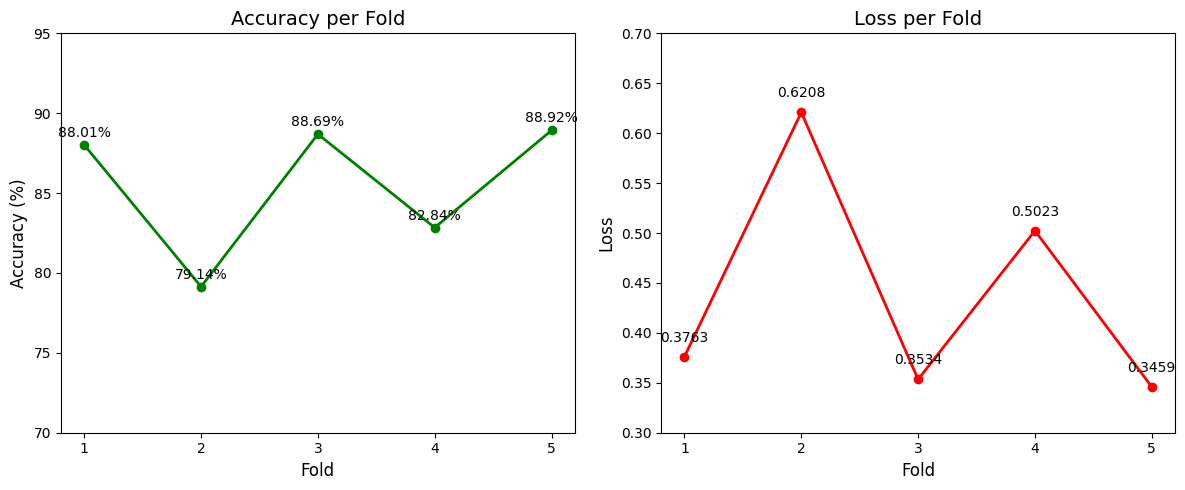

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Your results
folds = np.array([1, 2, 3, 4, 5])
accuracies = np.array([88.01, 79.14, 88.69, 82.84, 88.92])
losses = np.array([0.3763, 0.6208, 0.3534, 0.5023, 0.3459])

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(folds, accuracies, marker='o', color='green', linewidth=2)
plt.xticks(folds)
plt.ylim(70, 95)
plt.title('Accuracy per Fold', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
for i, acc in enumerate(accuracies):
    plt.text(folds[i], acc + 0.5, f"{acc:.2f}%", ha='center', fontsize=10)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(folds, losses, marker='o', color='red', linewidth=2)
plt.xticks(folds)
plt.ylim(0.3, 0.7)
plt.title('Loss per Fold', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Loss', fontsize=12)
for i, loss in enumerate(losses):
    plt.text(folds[i], loss + 0.015, f"{loss:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


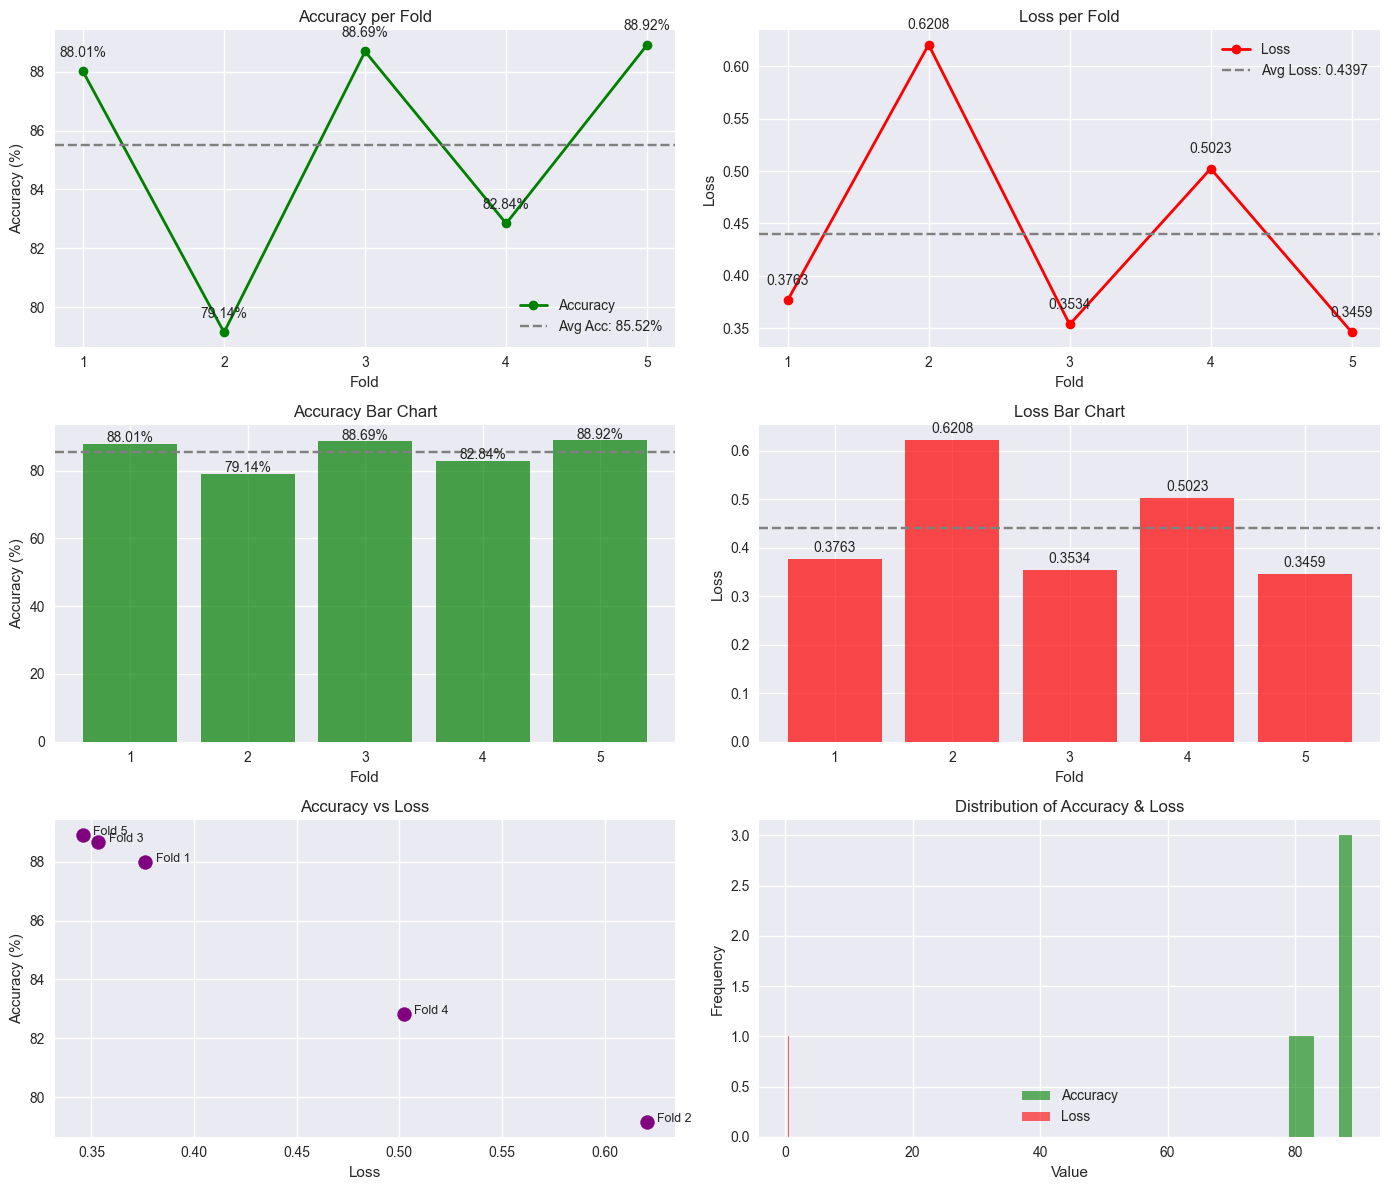

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
folds = np.array([1, 2, 3, 4, 5])
accuracies = np.array([88.01, 79.14, 88.69, 82.84, 88.92])
losses = np.array([0.3763, 0.6208, 0.3534, 0.5023, 0.3459])

avg_acc = np.mean(accuracies)
avg_loss = np.mean(losses)

# Set style
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1️⃣ Accuracy per fold (line)
axes[0, 0].plot(folds, accuracies, marker='o', color='green', linewidth=2, label='Accuracy')
axes[0, 0].axhline(avg_acc, color='gray', linestyle='--', label=f'Avg Acc: {avg_acc:.2f}%')
axes[0, 0].set_title('Accuracy per Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_xticks(folds)
for i, acc in enumerate(accuracies):
    axes[0, 0].text(folds[i], acc + 0.5, f"{acc:.2f}%", ha='center', fontsize=10)
axes[0, 0].legend()

# 2️⃣ Loss per fold (line)
axes[0, 1].plot(folds, losses, marker='o', color='red', linewidth=2, label='Loss')
axes[0, 1].axhline(avg_loss, color='gray', linestyle='--', label=f'Avg Loss: {avg_loss:.4f}')
axes[0, 1].set_title('Loss per Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xticks(folds)
for i, loss in enumerate(losses):
    axes[0, 1].text(folds[i], loss + 0.015, f"{loss:.4f}", ha='center', fontsize=10)
axes[0, 1].legend()

# 3️⃣ Bar chart - Accuracy
axes[1, 0].bar(folds, accuracies, color='green', alpha=0.7)
axes[1, 0].axhline(avg_acc, color='gray', linestyle='--')
axes[1, 0].set_title('Accuracy Bar Chart')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Accuracy (%)')
for i, acc in enumerate(accuracies):
    axes[1, 0].text(folds[i], acc + 0.5, f"{acc:.2f}%", ha='center', fontsize=10)

# 4️⃣ Bar chart - Loss
axes[1, 1].bar(folds, losses, color='red', alpha=0.7)
axes[1, 1].axhline(avg_loss, color='gray', linestyle='--')
axes[1, 1].set_title('Loss Bar Chart')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Loss')
for i, loss in enumerate(losses):
    axes[1, 1].text(folds[i], loss + 0.015, f"{loss:.4f}", ha='center', fontsize=10)

# 5️⃣ Accuracy vs Loss (scatter)
axes[2, 0].scatter(losses, accuracies, color='purple', s=100)
axes[2, 0].set_title('Accuracy vs Loss')
axes[2, 0].set_xlabel('Loss')
axes[2, 0].set_ylabel('Accuracy (%)')
for i in range(len(folds)):
    axes[2, 0].text(losses[i] + 0.005, accuracies[i], f"Fold {folds[i]}", fontsize=9)

# 6️⃣ Distribution histograms
axes[2, 1].hist(accuracies, bins=5, alpha=0.6, label='Accuracy', color='green')
axes[2, 1].hist(losses, bins=5, alpha=0.6, label='Loss', color='red')
axes[2, 1].set_title('Distribution of Accuracy & Loss')
axes[2, 1].set_xlabel('Value')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


In [11]:
model.save("model_fold_5.keras")